<a href="https://colab.research.google.com/github/aarush2612/WiDS/blob/main/Assignment_1_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade scikit-learn
# !pip install --upgrade xgboost

In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT']

df = yf.download(tickers, start, end)['Close']
df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2013-01-02,38.340000,27.620001
2013-01-03,37.750000,27.250000
2013-01-04,38.130001,26.740000
2013-01-07,37.939999,26.690001
2013-01-08,38.139999,26.549999


In [ ]:
ratios = df['ADBE'] / df['MSFT']
ratios.head()

,0
Date,
2013-01-02,1.388125
2013-01-03,1.385321
2013-01-04,1.425954
2013-01-07,1.421506
2013-01-08,1.436535


In [ ]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.04452696271616674

Clearly they are cointegrated for the chosen period so we will train our model on this data to use pairs trading.

In [ ]:
def calculate_rsi(data, window):
    delta = data.diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    return rsi/100

In [ ]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    ema_short = data.ewm(span=short_window, adjust=False).mean()
    ema_long = data.ewm(span=long_window, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line
macd, signal_line = calculate_macd(ratios)

In [ ]:
# def add_fft_features(df, ratios, n_components=10):
#     # Compute FFT
#     fft_values = np.fft.fft(ratios.fillna(0).values)

#     # Extract real & imaginary parts
#     fft_real = np.real(fft_values)
#     fft_imag = np.imag(fft_values)

#     for i in range(n_components):
#         df[f'fft_real_{i+1}'] = fft_real[i]
#         df[f'fft_imag_{i+1}'] = fft_imag[i]

#     #Add magnitude and phase
#     fft_magnitude = np.abs(fft_values)
#     fft_phase = np.angle(fft_values)

#     for i in range(n_components):
#         df[f'fft_magnitude_{i+1}'] = fft_magnitude[i]
#         df[f'fft_phase_{i+1}'] = fft_phase[i]

#     return df

# df = add_fft_features(df, ratios, n_components=10)

In [ ]:
df['mavg5'] = ratios.rolling(window=5, center=False).mean()
df['mavg20'] = ratios.rolling(window=20, center=False).mean()
df['mavg60'] = ratios.rolling(window=60, center=False).mean()
df['rsi14'] = calculate_rsi(ratios, 14)
df['rsi56'] = calculate_rsi(ratios, 56)
df['roc'] = ratios.pct_change(periods=5)
df['std_20'] = ratios.rolling(window=20, center=False).std()
df['lag'] = ratios.shift(1)
df['macd'] = macd
df['signal_line'] = signal_line
# df = add_fft_features(df, ratios, n_components=10)

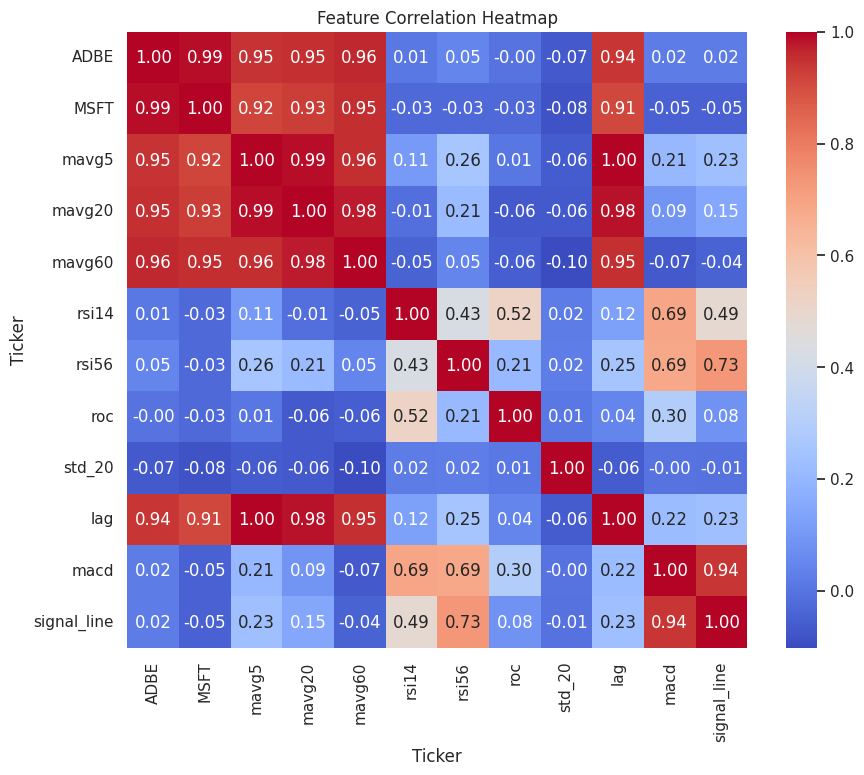

In [ ]:
# Seeing all the correlations between features
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Some observations:

*   The moving averages have a very high correlation which might be due to the series itself being stationary and the mean tending to stabalise eventually. I tried removing mavg20 from features but it does not lead to any significant performance improvement. So, it's been kept.
*   rsi14 and rsi56 have a good correlation score so including both should be a good choice to capture more patterns.



In [ ]:
from sklearn.ensemble import RandomForestRegressor
X = df[['mavg5','mavg20', 'mavg60', 'rsi14','rsi56', 'roc', 'std_20', 'lag', 'macd', 'signal_line']]
y = ratios

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, shuffle=False)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
# model2 = model = XGBRegressor(n_estimators=100, random_state=0, learning_rate=0.1)
# model2.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Mean Squared Error: 0.004639664219621448
Mean Absolute Error: 0.0538480312081822


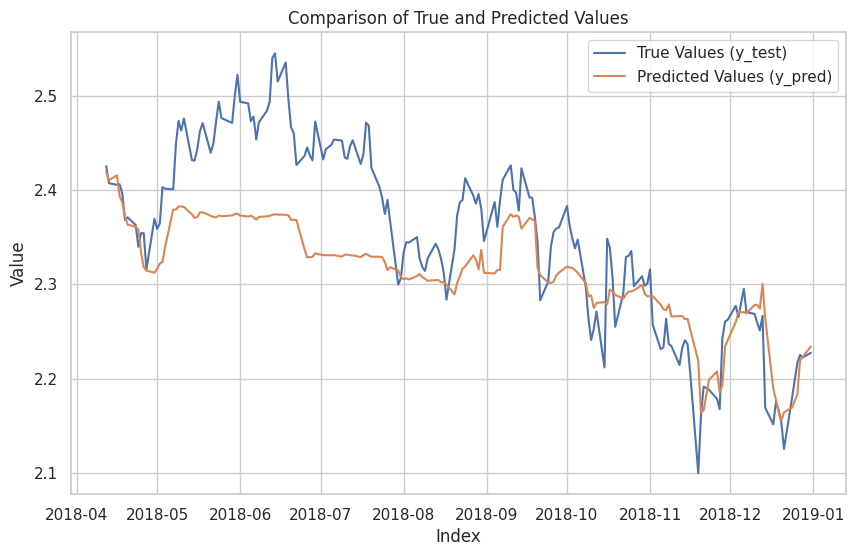

In [ ]:
y_pred=model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True Values (y_test)")
plt.plot(y_test.index, y_pred, label="Predicted Values (y_pred)")

# Add labels, title, and legend
plt.title("Comparison of True and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Clearly we do not see any overfitting.

In [ ]:
df['Predicted_Ratio'] = np.nan
df.iloc[-len(y_test):, df.columns.get_loc('Predicted_Ratio')] = y_pred

In [ ]:
df['Buy_Signal'] = (df['Predicted_Ratio'] > ratios + mae / 5)
df['Sell_Signal'] = (df['Predicted_Ratio'] + mae / 5 < ratios)

df['PnL'] = 0
positions = {'ADBE': 0, 'MSFT': 0}

# Iterate over positional indices and access the actual index via df.index
for i in range(len(df)):
    idx = df.index[i]  # Get the actual index value

    if df.loc[idx, 'Buy_Signal']:  # Use loc with the index value
        positions['ADBE'] += 10
        positions['MSFT'] -= 10*ratios[i]
    elif df.loc[idx, 'Sell_Signal']:
        positions['ADBE'] -= 10
        positions['MSFT'] += 10*ratios[i]

    # Update PnL
    df.loc[idx, 'PnL'] = positions['ADBE'] * df.loc[idx, 'ADBE'] + positions['MSFT'] * df.loc[idx, 'MSFT']

# Filter rows where 'Predicted_Ratio' is not NaN
filtered_df = df[df['Predicted_Ratio'].notna()]

# Calculate PnL change
filtered_df['PnL_Change'] = filtered_df['PnL'].diff()

print(filtered_df[['PnL']])

Ticker               PnL
Date                    
2018-04-12      0.000000
2018-04-13      0.000000
2018-04-16      0.000000
2018-04-17      0.000000
2018-04-18      9.502842
2018-04-19     36.362572
2018-04-20     33.454053
2018-04-23     41.275609
2018-04-24     61.718331
2018-04-25     61.181473
2018-04-26     62.481752
2018-04-27    137.167970
2018-04-30     33.348272
2018-05-01     64.684270
2018-05-02     42.289063
2018-05-03   -138.753135
2018-05-04   -130.803748
2018-05-07   -127.683728
2018-05-08   -491.480859
2018-05-09   -714.497358
2018-05-10   -622.756917
2018-05-11   -758.618942
2018-05-14   -241.940227
2018-05-15   -234.525988
2018-05-16   -402.576245
2018-05-17   -673.093345
2018-05-18   -801.829330
2018-05-21   -292.997389
2018-05-22   -460.806101
2018-05-23   -899.300955
2018-05-24  -1317.167607
2018-05-25   -957.753477
2018-05-29   -843.613861
2018-05-30  -1515.759505
2018-05-31  -2031.282676
2018-06-01  -1349.352196
2018-06-04  -1318.444455
2018-06-05   -802.538181


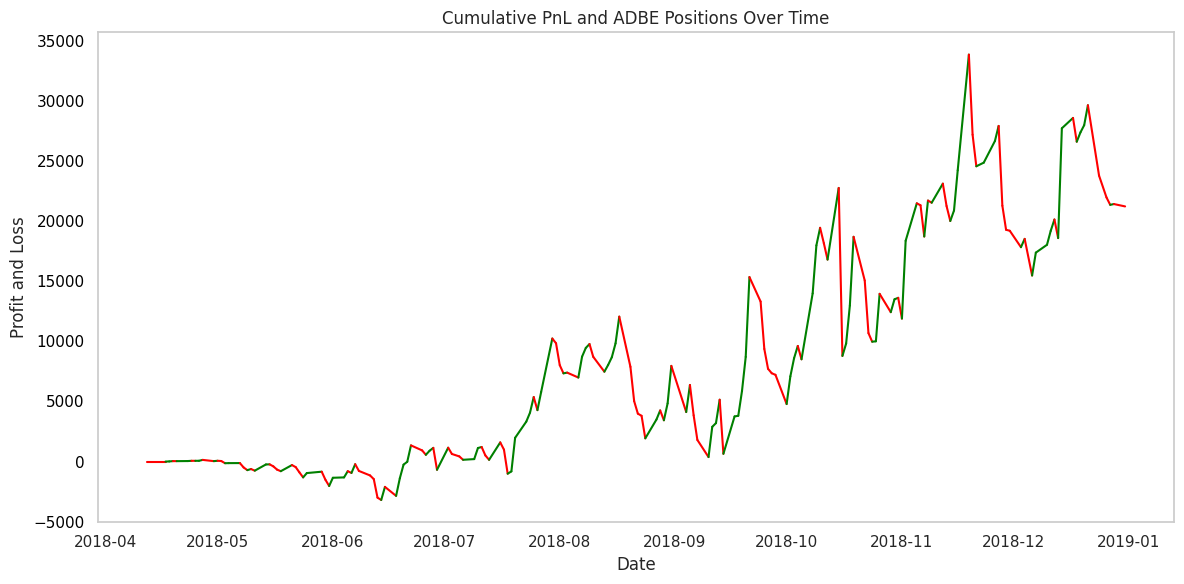

In [ ]:
# Plot the PnL with color-coded segments
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(1, len(filtered_df)):
    if filtered_df['PnL_Change'].iloc[i] > 0:  # PnL is increasing
        ax1.plot(filtered_df.index[i-1:i+1],
                 filtered_df['PnL'].iloc[i-1:i+1],
                 color='green')
    else:  # PnL is decreasing
        ax1.plot(filtered_df.index[i-1:i+1],
                 filtered_df['PnL'].iloc[i-1:i+1],
                 color='red')

# Customize the primary y-axis
ax1.set_title("Cumulative PnL and ADBE Positions Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Profit and Loss")
ax1.tick_params(axis='y', labelcolor='black')

# # Create a secondary y-axis for the bar graph (ADBE positions only)
# ax2 = ax1.twinx()
# ax2.bar(filtered_df.index, filtered_df['ADBE_Position'], color='blue', alpha=0.3, width=1)
# ax2.set_ylabel("ADBE Positions", color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)

tickers = ['ADBE','MSFT']

df1 = yf.download(tickers, start, end)['Close']
df1

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2019-01-02,224.570007,101.120003
2019-01-03,215.699997,97.400002
2019-01-04,226.190002,101.930000
2019-01-07,229.259995,102.059998
2019-01-08,232.679993,102.800003
2019-01-09,235.429993,104.269997
2019-01-10,237.770004,103.599998
2019-01-11,237.550003,102.800003
2019-01-14,234.559998,102.050003


In [ ]:
S1 = df1['ADBE']
S2 = df1['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.670202349107168

Clearly pvalue is much greater than 0.05 so these stocks are not cointegrated from 2019 to 2020. Still, using our model:

In [ ]:
ratios1=df1['ADBE']/df1['MSFT']

In [ ]:
macd_1, signal_line_1 = calculate_macd(ratios)

In [ ]:
df1['mavg5'] = ratios1.rolling(window=5, center=False).mean()
df1['mavg20'] = ratios1.rolling(window=20, center=False).mean()
df1['mavg60'] = ratios1.rolling(window=60, center=False).mean()
df1['rsi14'] = calculate_rsi(ratios, 14)
df1['rsi56'] = calculate_rsi(ratios, 56)
df1['roc'] = ratios1.pct_change(periods=5)
df1['std_20'] = ratios1.rolling(window=20, center=False).std()
df1['lag'] = ratios1.shift(1)
df1['macd'] = macd_1
df1['signal_line'] = signal_line_1

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X = df1[['mavg5','mavg20', 'mavg60', 'rsi14','rsi56', 'roc', 'std_20', 'lag', 'macd', 'signal_line']]

y = ratios1

Mean Squared Error: 0.0028926322165334713
Mean Absolute Error: 0.030680771465800543


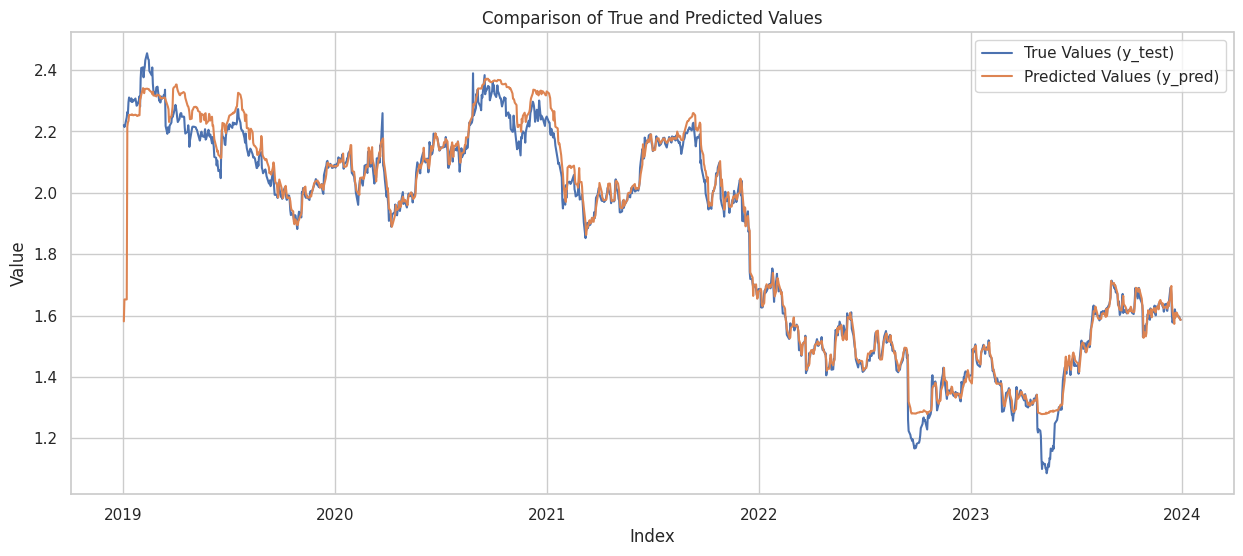

In [ ]:
y_pred_1=model.predict(X)

mse = mean_squared_error(ratios1, y_pred_1)
mae = mean_absolute_error(ratios1, y_pred_1)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(15, 6))
plt.plot(ratios1.index, ratios1, label="True Values (y_test)")
plt.plot(ratios1.index, y_pred_1, label="Predicted Values (y_pred)")

# Add labels, title, and legend
plt.title("Comparison of True and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
z = y_pred_1-ratios1
z_positive = sum(1 for i in z if i > mae/5)
z_negative = sum(1 for i in z if i <-mae/5)
print(z_positive)
print(z_negative)

688
290


The model generates **both buy and sell signals**, so these features will work.

In [ ]:
df1['Predicted_Ratio'] = np.nan
df1.iloc[-len(y_test):, df1.columns.get_loc('Predicted_Ratio')] = y_pred

In [ ]:
df1['Buy_Signal'] = (df1['Predicted_Ratio'] > ratios1 + mae / 5)
df1['Sell_Signal'] = (df1['Predicted_Ratio'] < ratios1 - mae / 5)

df1['PnL'] = 0
positions1 = {'ADBE': 0, 'MSFT': 0}

# Iterate over positional indices and access the actual index via df.index
for i in range(len(df1)):
    idx = df1.index[i]  # Get the actual index value

    if df1.loc[idx, 'Buy_Signal']:  # Use loc with the index value
        positions1['ADBE'] += 10
        positions1['MSFT'] -= 10
    elif df1.loc[idx, 'Sell_Signal']:
        positions1['ADBE'] -= 10
        positions1['MSFT'] += 10

    # Update PnL
    df1.loc[idx, 'PnL'] = positions1['ADBE'] * df1.loc[idx, 'ADBE'] + positions1['MSFT'] * df1.loc[idx, 'MSFT']

# Filter rows where 'Predicted_Ratio' is not NaN
filtered_df1 = df1[df1['Predicted_Ratio'].notna()]

# Calculate PnL change
filtered_df1['PnL_Change'] = filtered_df1['PnL'].diff()

final_profit = filtered_df1['PnL'].iloc[-1]
print(filtered_df1[['PnL']])

Ticker                PnL
Date                     
2023-04-12     864.000244
2023-04-13    1779.199829
2023-04-14    2797.199707
2023-04-17    3564.801025
2023-04-18    4458.999634
2023-04-19    5499.598389
2023-04-20    6590.501709
2023-04-21    7352.800293
2023-04-24    8601.300659
2023-04-25    9416.998291
2023-04-26    7445.900269
2023-04-27    7990.803223
2023-04-28    9138.998413
2023-05-01    9602.599487
2023-05-02    9487.500000
2023-05-03    6536.000977
2023-05-04    5171.397095
2023-05-05    6795.000000
2023-05-08    6727.900696
2023-05-09    7129.998779
2023-05-10    6659.098206
2023-05-11    6923.400269
2023-05-12    6090.402527
2023-05-15    8690.405273
2023-05-16    8342.498779
2023-05-17   11083.801270
2023-05-18   11315.700989
2023-05-19   14814.801025
2023-05-22   14752.298584
2023-05-23   16548.001099
2023-05-24   16092.101135
2023-05-25   21164.794922
2023-05-26   27225.000000
2023-05-30   29240.000000
2023-05-31   31289.997864
2023-06-01   33901.204834
2023-06-02  

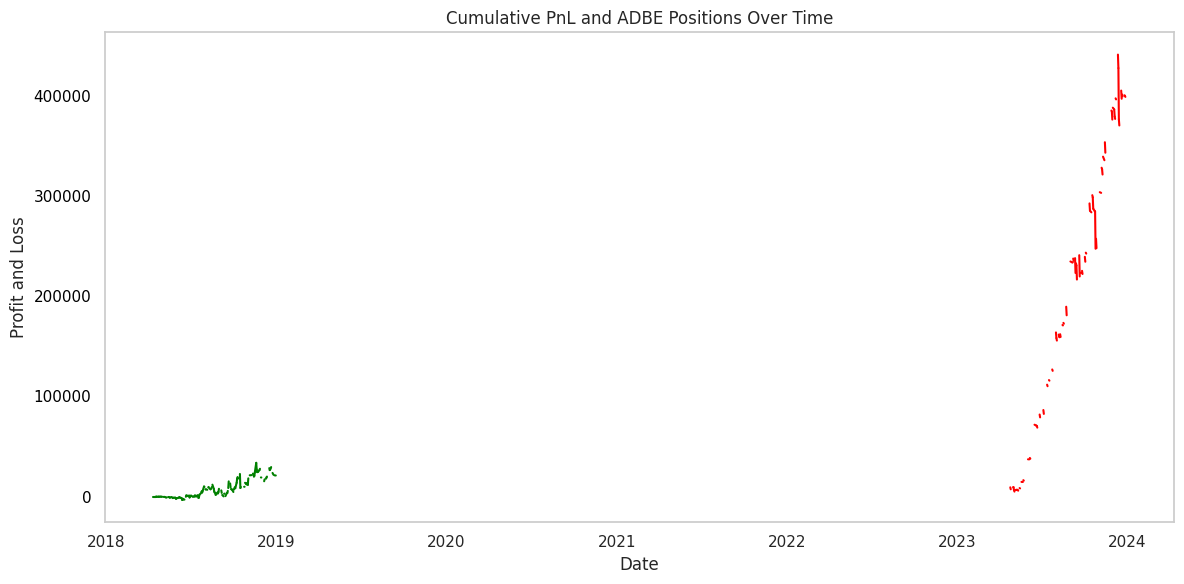

In [ ]:
# Plot the PnL with color-coded segments
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(1, len(filtered_df1)):
    if filtered_df1['PnL_Change'].iloc[i] > 0:  # PnL is increasing
        ax1.plot(filtered_df.index[i-1:i+1],
                 filtered_df['PnL'].iloc[i-1:i+1],
                 color='green')
    else:  # PnL is decreasing
        ax1.plot(filtered_df1.index[i-1:i+1],
                 filtered_df1['PnL'].iloc[i-1:i+1],
                 color='red')

# Customize the primary y-axis
ax1.set_title("Cumulative PnL and ADBE Positions Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Profit and Loss")
ax1.tick_params(axis='y', labelcolor='black')

# # Create a secondary y-axis for the bar graph (ADBE positions only)
# ax2 = ax1.twinx()
# ax2.bar(filtered_df.index, filtered_df['ADBE_Position'], color='blue', alpha=0.3, width=1)
# ax2.set_ylabel("ADBE Positions", color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
# plt.text(final_profit, final_profit, f"Final Profit: {final_profit:.2f}",
#          fontsize=10, color="green", horizontalalignment='right')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
print(f"The final profit is {final_profit:,.2f}")

The final profit is 401,419.14


Some additional points/mistakes I learned😅:

*   When dealing with time series and using features like mavg, never forget to set shuffle = False.
*   Viewing in frequency domain I did not find any primary seasonal patterns in the series.

*   When changing period till 2024 the buy/sell ratio dropped by 10% which indicates that MSFT had a better rally after 2020






